## Optimization Step 4
This script computes the shortest driving distance between nodes associated with DCFC and exits. 

1. Load NC road, DCFC locations and exits 

2. Match each DCFC and exit with the nearest node on NC road network 

3. Find the shortest distance of each DCFC node to one exit node 

4. Visualize the results by >50 miles and <50 miles categories 

<i>Yiwen Wang | 04/27/2020</i>

In [1]:
#Import packages
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

### Load the data: NC road, DCFC locations, and exits

In [2]:
#Load in the NC road network
nc_graph = ox.load_graphml('NC_roads.graphml',folder='../Data/OSM/')

In [3]:
#Load in the DCFC locations as pandas dataframe
dcfc_df = pd.read_csv('../Data/NREL/DCFC.csv')

In [4]:
#Convert the coordinates of DCFC to a geopandas dataframe
geom_points = [Point(xy) for xy in zip(dcfc_df['longitude'],dcfc_df['latitude'])]
dcfc_gdf = gpd.GeoDataFrame(dcfc_df,geometry=geom_points,crs=4326)

In [8]:
#Load exits as a geopandas dataframe
exits_gdf = gpd.read_file('../Data/MJBA/Exits.shp')

### Get the nearest node of each DCFC and exit point

In [5]:
#Define a function to extract the nearest node ID for a point object
def get_nodeid(thePoint):
    #Get the yx tuple
    yx = (thePoint.y,thePoint.x)
    #Fetch the node nearest the xy tuple among NC road network
    node_id = ox.get_nearest_node(nc_graph,yx)
    #Return the node id
    return node_id

In [6]:
#Apply the function to each point in the DCFC geodataframe, adding node ID as a column
dcfc_gdf['node_id'] = dcfc_gdf['geometry'].apply(get_nodeid)

In [9]:
#Apply the function to each point in the Exits geodataframe, adding node ID as a column
exits_gdf['node_id'] = exits_gdf['geometry'].apply(get_nodeid)

In [11]:
#Create lists from the values
nodes_dcfc = dcfc_gdf['node_id'].unique()
nodes_exits = exits_gdf['node_id'].unique()

<b>all_source_dijkstra_path_length(): </b>

Compute shortest path lengths between all nodes in a weighted graph.

In [86]:
#For each node, compute distance to other nodes, which are within 100 miles
#Save as a tuple including a dictionary 
theDistances = nx.all_pairs_dijkstra_path_length(G = nc_graph,
                                                    cutoff = 100*1609.34,
                                                    weight = 'length')

In [87]:
#Loop through the results and extract the distances associated with DCFC nodes
distance_data = {} #create a dictionary 
for distItem in theDistances:
    startNode_id = distItem[0] # the first item returned is the source 
    path_data = distItem[1] # the second item returned is a distionary of distances 
    #for the startnode that are associated with DCFC 
    if startNode_id in nodes_dcfc:
        endNodes = set(path_data.keys())
        # filter endnodes which are associted with exits 
        valid_endNodes = endNodes.intersection(set(nodes_exits)) 
        if len(valid_endNodes) > 0:
            for node in valid_endNodes:
                # update with smaller distance if the node already exits 
                if node in distance_data.keys():
                    if path_data[node] < distance_data[node]: 
                        distance_data[node] = path_data[node]
                else:
                    #if not exits, add it 
                    distance_data[node] = path_data[node]

In [88]:
#Create a dataframe of the distances
df = pd.DataFrame()                       #Create an empty dataframe
df['node_id'] = distance_data.keys()       #Add the node_ids to the dataframe
df['distance'] = distance_data.values()    #Add the distances (in meters) to the dataframe
df['distance'] = df['distance']/1609.34   #Convert distances to miles
df.head()

,node_id,distance
0,195770883,4.219215
1,195397123,4.819433
2,373638664,21.317632
3,3115819531,7.618521
4,3737060875,5.318815


In [89]:
#Join the data to the exits data, adding  
exits_gdf1 = pd.merge(left=exits_gdf,   
                      right=df, 
                      left_on='node_id', 
                      right_on='node_id',
                      how='left')        
# keeps all records in left dataframe  

In [107]:
#Save the data to a shapefile
exits_gdf1.to_file('../Data/exits_distance.shp')

## Visualization

189

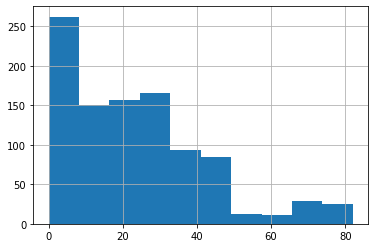

In [109]:
#Plot a histogram of distances
exits_gdf1['distance'].hist(bins=10);
exits_gdf1['distance'].isna().sum()

In [110]:
#Create a list of exit colors, for plotting
exit_colors = []
for d in exits_gdf1['distance']:
    if d < 50: exit_colors.append('grey')  #Show exits <50 miles from DCFC as grey
    else: exit_colors.append('red')        #Show all other exits as red

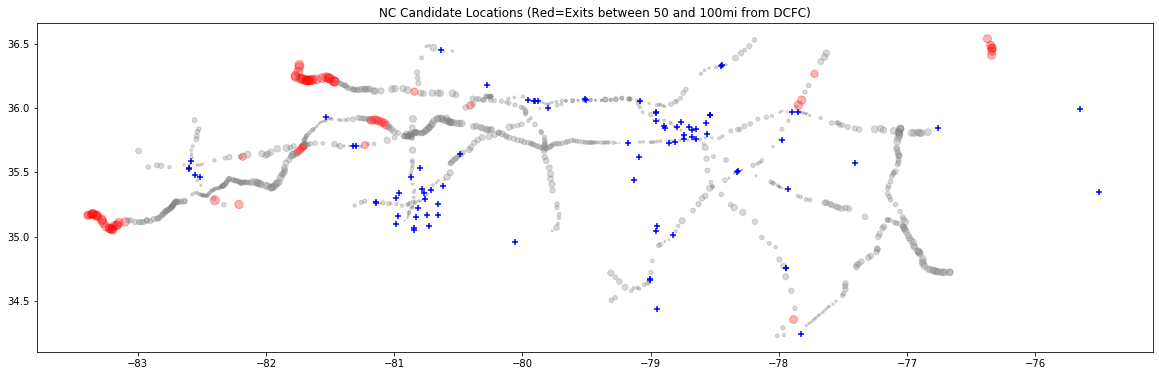

In [111]:
#Plot exits and charger locations
ax = exits_gdf1.plot(markersize='distance', #Make further exits larger
                     figsize=(20,15),       #Size of figure
                     color=exit_colors,     #Use colors set above
                     alpha=0.3)             #Set to mostly transparent
ax.set_title("NC Candidate Locations (Red=Exits between 50 and 100mi from DCFC)")

#Add the DCFC locations as small blue crosses
dcfc_gdf.plot(color='blue',marker='+',ax=ax)

#red exits: must drive > 50 miles to find a exit that has nearby DCFC
#grey exits: drive < 50 miles to find a exit that has nearby DCFC